# Analyse second run
(this was a run using CNN based on manually labelled data)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json
import getpass

#import ML liberaries
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Get the data from CSV file
data = pd.read_csv('data_output2024-01-04 22_56_03.557501.csv')

In [3]:
# get timestamp in the right format 
data['timestamp'] = data['timestamp'].str.replace('_', ':')
data['timestamp'] = pd.to_datetime(data['timestamp'], dayfirst=True)

# Create a column that counts the time in seconds since the laast frame
data['time-sec'] = (data['timestamp'] - data['timestamp'].shift(1)).dt.total_seconds().round(2)

In [4]:
data.head(20)

,motion,timestamp,i,LMR,model_prediction,img,time-sec
0,SlowForward,2024-01-04 22:54:36.807333,0,2,1,"[[108, 107, 120, 111, 115, 119, 124, 125, 132,...",NaN
1,SlowForward,2024-01-04 22:54:37.240463,1,2,1,"[[108, 109, 114, 117, 119, 122, 125, 127, 130,...",0.43
2,SlowForward,2024-01-04 22:54:37.362013,2,2,1,"[[110, 110, 112, 121, 122, 123, 129, 130, 135,...",0.12
3,SlowForward,2024-01-04 22:54:37.494972,3,2,1,"[[106, 110, 111, 117, 118, 118, 124, 127, 132,...",0.13
4,SlowForward,2024-01-04 22:54:37.628129,4,2,1,"[[107, 111, 112, 116, 119, 120, 125, 125, 132,...",0.13
5,SlowForward,2024-01-04 22:54:37.760948,5,2,1,"[[108, 113, 112, 119, 121, 121, 126, 125, 133,...",0.13
6,SlowForward,2024-01-04 22:54:37.895142,6,2,1,"[[109, 112, 110, 116, 118, 119, 123, 126, 133,...",0.13
7,SlowForward,2024-01-04 22:54:38.028187,7,2,1,"[[109, 113, 114, 119, 119, 120, 127, 126, 132,...",0.13
8,SlowForward,2024-01-04 22:54:38.161907,8,2,1,"[[109, 112, 114, 116, 120, 120, 126, 126, 132,...",0.13
9,SlowForward,2024-01-04 22:54:38.296730,9,2,1,"[[110, 109, 113, 117, 118, 119, 122, 125, 129,...",0.13


In [5]:
len(data)

647

## 1. Visually Explore training data

In [6]:
# A function that takes the index and produce the image in that index in dataframe

def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['img'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()


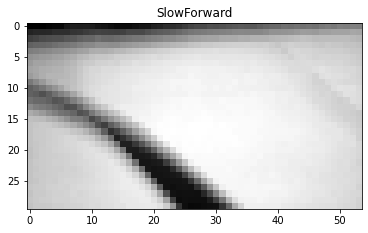

In [7]:
review_data (100)

In [8]:
    
def preview_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # number of histograms per raws & columns
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]} , {data['time-sec'][i]}") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

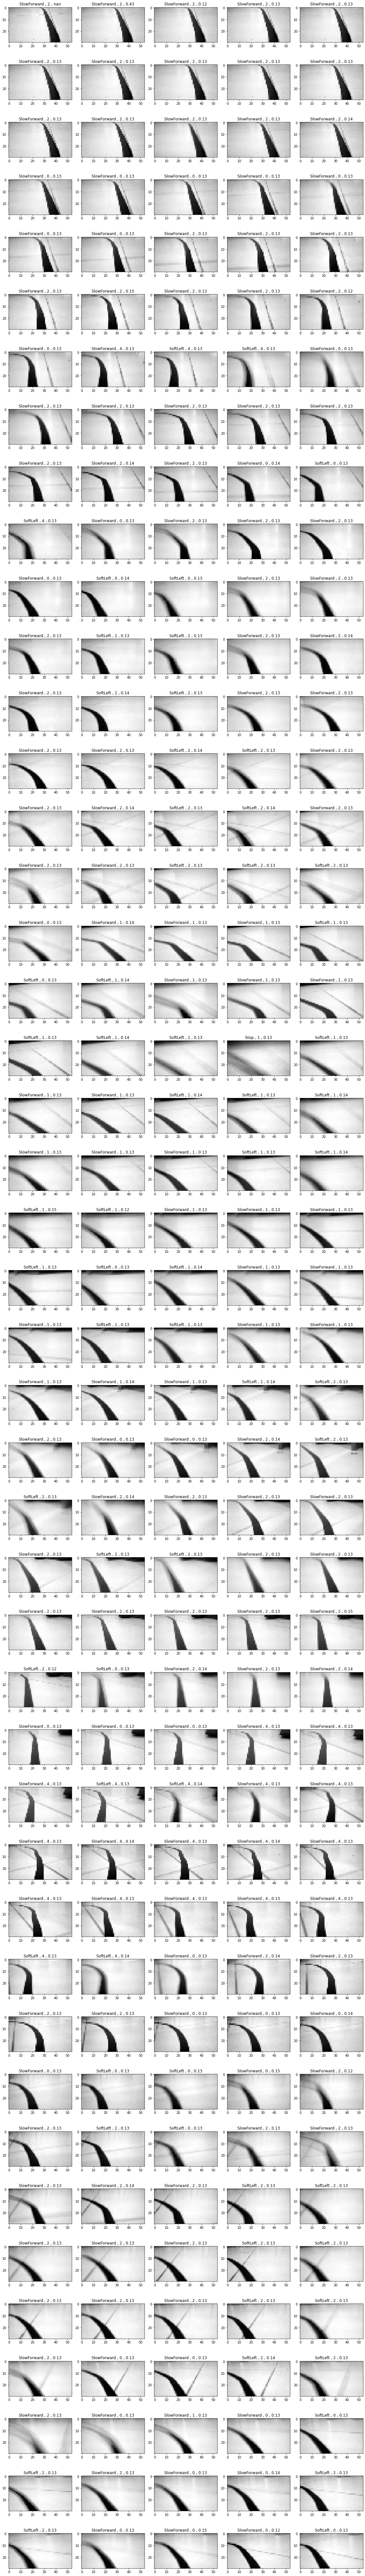

In [9]:
preview_dataset(data = data, 
                START_FRAME = 0, 
                END_FRAME = 225 )